# Testing the algorithms

- perform STFT and Spectrogram 
- select point cloud 
- select redpoints alongside with meta-data of the time , all this acting as a fingerprint 
- hash and store 

In [133]:
import os 
import numpy as np 
import pyaudio 
import matplotlib.pyplot as plt

# from scipy.signal import spectrogram
import librosa 
import ipywidgets as widgets
from IPython.display import display, Audio


import sounddevice as sd
import wave

In [134]:

fs = 44100  # Sampling frequency
DURATION = 10  # Duration in seconds

# Widget for starting and stopping recording
record_button = widgets.Button(description="Record")
play_button = widgets.Button(description="Play")
status_label = widgets.Label(value="Click 'Record' to start recording.")

# Variable to store the recorded audio
recorded_audio = None

def record_audio(change):
    global recorded_audio
    status_label.value = "Recording..."
    try:
        # Record audio
        recorded_audio = sd.rec(int(DURATION * fs), samplerate=fs, channels=1, dtype=np.float32)
        sd.wait()  # Wait until recording is finished
        status_label.value = "Recording complete! Click 'Play' to listen."
    except Exception as e:
        status_label.value = f"Error: {str(e)}"

def play_audio(change):
    if recorded_audio is not None:
        # Play the recorded audio
        sd.play(recorded_audio, fs)
        sd.wait()  # Wait until playback is finished
    else:
        status_label.value = "No audio recorded yet. Please record first."
        print('type of audio: ', type(record_audio))

# Link buttons to their functions
record_button.on_click(record_audio)
play_button.on_click(play_audio)


# Display widgets
display(record_button, play_button, status_label)

Button(description='Record', style=ButtonStyle())

Button(description='Play', style=ButtonStyle())

Label(value="Click 'Record' to start recording.")

In [136]:
print('type of recorded audio : ', type(recorded_audio))
print('shape of recorded audio :', recorded_audio.shape)

type of recorded audio :  <class 'numpy.ndarray'>
shape of recorded audio : (441000, 1)


## (Skip this) Spectrogram on a random signal

frequenceis shape :  (129,)
times shape  (14,)
Sxx shape :  (129, 14)


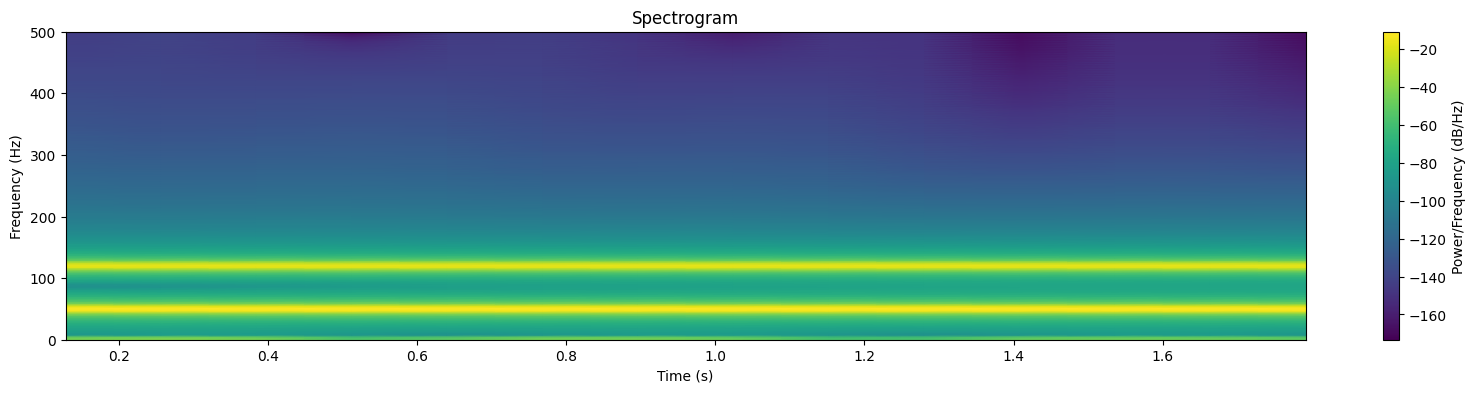

In [6]:
from scipy.signal import spectrogram

# Example signal
fs = 1000  # Sampling frequency in Hz
T = 2      # Duration in seconds
N = fs * T  # Total number of samples
t = np.linspace(0, T, N, endpoint=False)  # Time vector
x = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)  # Signal

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(x, fs, nperseg=256, noverlap=128, window='hann')

print('frequenceis shape : ', frequencies.shape)
print('times shape ', times.shape)
print('Sxx shape : ', Sxx.shape)

# Plot the spectrogram
plt.figure(figsize=(20, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')  # Convert to dB scale
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

## Spectrogram and keypoints 

sr =  22050


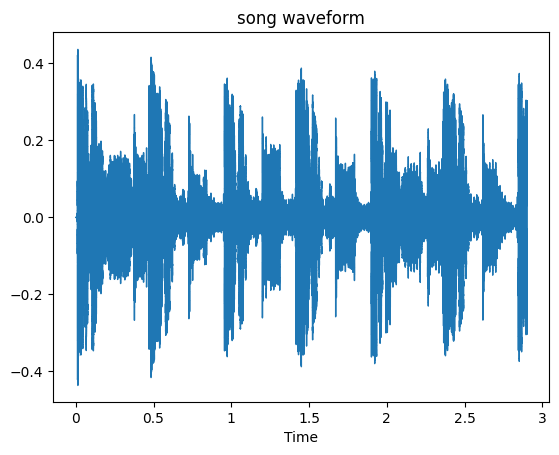

In [147]:
# reading and displaying an audio signal 

from scipy.signal import find_peaks

song_name = 'bob-sinclar-world-hold-on-official-video (1).mp3'
audio_file = os.path.join('database', song_name)

y, sr = librosa.load(audio_file)
print('sr = ', sr)
duration = 4 * sr # 10 seconds 
begin = int(1.1 * sr)

y = y[begin:duration]
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y=y, sr=sr, ax=ax)
plt.title('song waveform')
plt.show()

In [148]:
# performing STFT and finding peaks 

n_fft = 2048 #  Number of samples in each FFT window. Higher values improve frequency resolution but reduce time resolution
hop_length = n_fft // 4  # 512, The number of samples between successive FFT frames. Smaller values increase overlap, providing smoother time representation.

print('shape of y : ', y.shape)
print('y.dtype : ', y.dtype)


def spectrogram(y): 

    n_fft = 2048 #  Number of samples in each FFT window. Higher values improve frequency resolution but reduce time resolution
    hop_length = n_fft // 4  # 512, The number of samples between successive FFT frames. Smaller values increase overlap, providing smoother time representation.

    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)
    spectrogram_dB = librosa.amplitude_to_db(spectrogram, ref=np.max)

    return spectrogram_dB


spectrogram_dB = spectrogram(y)

# spectrogram : 
# each row represent a frequency bin
# each column represent a time bin  
# actual time = column index * hop_length / sampling rate (sr)
# actual frequency = row index * sr / n_fft



shape of y :  (63945,)
y.dtype :  float32


In [149]:
(spectrogram_dB.shape[0]-1) * sr / n_fft # in db 

11025.0

In [150]:
# spectrogram_dB[0].shape
idx = int(1.5* hop_length / sr )
print(spectrogram_dB[:,idx])

[-63.099735 -41.26133  -31.120892 ... -80.       -80.       -80.      ]


In [170]:
print(spectrogram_dB.shape)


def find_peaks_spectrogram(spectrogram_dB): 

    peaks = []
    for t in range(spectrogram_dB.shape[1]):  # Loop over time frames
        
        # Apply the threshold in dB, adjusting the factor if necessary
        threshold_dB =  0.2*np.min(spectrogram_dB[:, t])  # threshold in dB
        # threshold_dB = -10
        # print(threshold_dB)
        freq_peaks, _ = find_peaks(spectrogram_dB[:, t], height=threshold_dB)  # Apply threshold to dB values

        for f in freq_peaks:
            frequency = f * sr / n_fft  # Actual frequency in Hz
            time_point = t * hop_length / sr  # Time in seconds
            peaks.append((time_point, frequency))  # Store (time_in_seconds, frequency_bin)


    peaks = np.array(peaks)
    return peaks 

peaks = find_peaks_spectrogram(spectrogram_dB)
print(peaks)

(1025, 125)
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-16.0
-15.571807861328125
[[0.00000000e+00 1.61499023e+02]
 [2.32199546e-02 5.38330078e+01]
 [2.32199546e-02 1.07666016e+02]
 [2.32199546e-02 1.50732422e+02]
 [4.64399093e-02 5.38330078e+01]
 [4.64399093e-02 7.53662109e+01]
 [6.96598639e-02 5.3833007

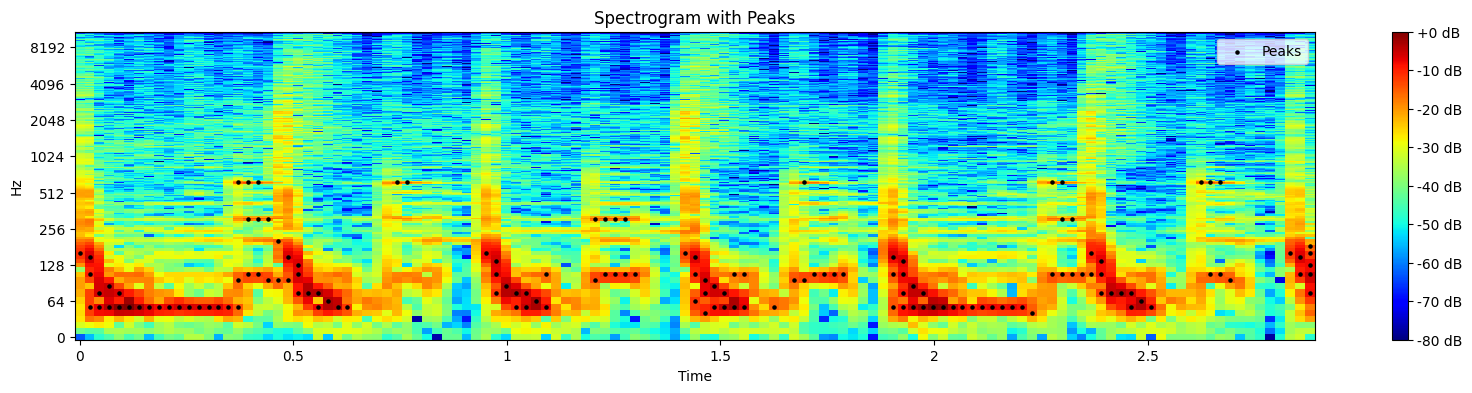

In [171]:
# Plotting
plt.figure(figsize=(20, 4))

# displaying the Spectrogram
librosa.display.specshow(spectrogram_dB, sr=sr, cmap='jet', hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')


plt.scatter(peaks[:, 0], peaks[:, 1], color='black', s=5, label='Peaks')

plt.title('Spectrogram with Peaks')
plt.legend()
plt.show()

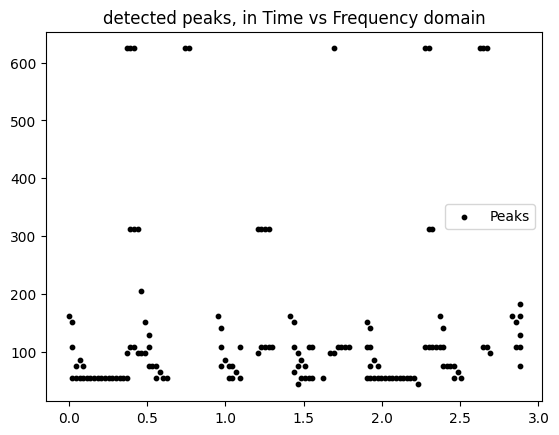

In [172]:
plt.scatter(peaks[:, 0], peaks[:, 1], color='black', s=10, label='Peaks')

plt.title('detected peaks, in Time vs Frequency domain')
plt.legend()
plt.show()

In [144]:
# for debugging purposes 
print('sr: ', sr)
print('shape of y :', y.shape)
print('shape of spectrogram : ',spectrogram_dB.shape)
print('spectrogram[1025,0] = ', spectrogram_dB[1024,0])

sr:  22050
shape of y : (44100,)
shape of spectrogram :  (1025, 87)
spectrogram[1025,0] =  -80.0


## Anchor points selection and hashing 

etapes:    
- select anchor point
- ROI window
- encode (hash) for each anchor point and corresponiding keypoints inside the ROI 

In [145]:
import hashlib

# Define the ROI size
ROI_TIME = 0.5  # in seconds
ROI_FREQ = 100  # in Hz

# Function to generate hash
def generate_hash(fa, ta, fk, tk):
    hash_input = f"{fa}-{fk}-{tk-ta}".encode('utf-8')
    return hashlib.sha1(hash_input).hexdigest()

# Select anchor points based on the highest amplitude within a certain region
def select_anchor_points(peaks, spectrogram_dB, num_anchors=5):
    anchor_points = []
    for t in range(0, spectrogram_dB.shape[1], int(ROI_TIME * sr / hop_length)):
        for f in range(0, spectrogram_dB.shape[0], int(ROI_FREQ * n_fft / sr)):

            region_peaks = peaks[
                (peaks[:, 0] >= t * hop_length / sr) & (peaks[:, 0] < (t + int(ROI_TIME * sr / hop_length)) * hop_length / sr) &
                (peaks[:, 1] >= f * sr / n_fft) & (peaks[:, 1] < (f + int(ROI_FREQ * n_fft / sr)) * sr / n_fft)
            ]
            
            if len(region_peaks) > 0:
                max_peak = region_peaks[np.argmax(spectrogram_dB[region_peaks[:, 1].astype(int) * n_fft // sr, region_peaks[:, 0].astype(int) * sr // hop_length])]
                anchor_points.append(max_peak)
    return np.array(anchor_points)


anchor_points = select_anchor_points(peaks, spectrogram_dB)


def get_hashes(anchor_points, peaks): 

    # List to store the hashes
    hashes = []

    # Iterate over each anchor point
    for anchor in anchor_points:
        ta, fa = anchor

        # Define the ROI
        roi_peaks = peaks[(peaks[:, 0] >= ta) & (peaks[:, 0] <= ta + ROI_TIME) & (peaks[:, 1] >= fa - ROI_FREQ) & (peaks[:, 1] <= fa + ROI_FREQ)]
        
        # Generate hashes for keypoints in the ROI
        for keypoint in roi_peaks:
            tk, fk = keypoint
            if (tk, fk) != (ta, fa):  # Exclude the anchor point itself
                hash_value = generate_hash(fa, ta, fk, tk)
                hashes.append(((fa, fk, tk - ta), ta, hash_value))

    return hashes

hashes = get_hashes(anchor_points, peaks)

print('number of hashes: ', len(hashes))
# Print the hashes
for h in hashes:
    print(h)


number of hashes:  55
((53.8330078125, 86.1328125, 0.0), 1.1609977324263039, '83961e0a65d0a6687d9ce4ab4587422a5fc6adfb')
((53.8330078125, 53.8330078125, 0.02321995464852611), 1.1609977324263039, '0550f64c8ca8e6a3984bf132e58f0801eaf8c2dd')
((53.8330078125, 75.3662109375, 0.02321995464852611), 1.1609977324263039, '042de1bb01d79d85c9271ef95feb4123d31dee09')
((53.8330078125, 53.8330078125, 0.04643990929705222), 1.1609977324263039, 'e3045f5261c32fb357cf7fdf047060c68b75596b')
((53.8330078125, 53.8330078125, 0.0696598639455781), 1.1609977324263039, 'c93276071251a5be794176b968cc443265168d54')
((53.8330078125, 53.8330078125, 0.09287981859410421), 1.1609977324263039, 'c9152d632cb9f1ca3f93027ab00741fad4ecf16c')
((53.8330078125, 53.8330078125, 0.11609977324263032), 1.1609977324263039, '82920155c8575e806fbc2a2343064fc6a79d0c33')
((53.8330078125, 53.8330078125, 0.13931972789115643), 1.1609977324263039, 'dd2a2f590737fc214884ce2108ab7af654c4639f')
((53.8330078125, 53.8330078125, 0.16253968253968254), 

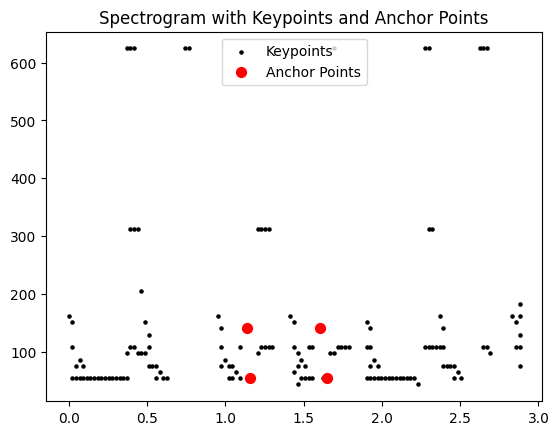

In [173]:
# Plotting

# Displaying the Spectrogram
# librosa.display.specshow(spectrogram_dB, sr=sr, cmap='jet', hop_length=hop_length, x_axis='time', y_axis='log')
# plt.colorbar(format='%+2.0f dB')

# Plotting the keypoints
plt.scatter(peaks[:, 0], peaks[:, 1], color='black', s=5, label='Keypoints')

# Plotting the anchor points
plt.scatter(anchor_points[:, 0], anchor_points[:, 1], color='red', s=50, label='Anchor Points')

plt.title('Spectrogram with Keypoints and Anchor Points')
plt.legend()
plt.show()

# hashing the whole song file 

In [128]:
def generate_hash_audio_file(file_path):

    y_full, _ = librosa.load(file_path)
    spectrogram_dB_full = spectrogram(y_full)
    peaks_full= find_peaks_spectrogram(spectrogram_dB_full)
    anchor_points_full = select_anchor_points(peaks_full, spectrogram_dB_full)
    hashes_full = get_hashes(anchor_points_full, peaks_full)

    return hashes_full


def generate_hash_audio(y):

    spectrogram_dB_full = spectrogram(y)
    peaks_full= find_peaks_spectrogram(spectrogram_dB_full)
    anchor_points_full = select_anchor_points(peaks_full, spectrogram_dB_full)
    hashes_full = get_hashes(anchor_points_full, peaks_full)


    return hashes_full


song_name = 'bob-sinclar-world-hold-on-official-video (1).mp3'
audio_file = os.path.join('database', song_name)
hashes_full = generate_hash_audio_file(audio_file)

In [58]:
# Extract the hash values from both lists
hash_values_full = set(h[2] for h in hashes_full)
hash_values = set(h[2] for h in hashes)

# Find the common hashes
common_hashes = hash_values_full.intersection(hash_values)

# Print the number of common hashes
print(f"Number of common hashes: {len(common_hashes)}")

Number of common hashes: 46


Generating database of hashing 


In [116]:
import json

def generate_hashes_for_database(database_folder):
    song_hashes = {}
    for song_file in os.listdir(database_folder):
        if song_file.endswith('.mp3'):
            audio_file_path = os.path.join(database_folder, song_file)
            hashes = generate_hash_audio_file(audio_file_path)
            song_hashes[song_file] = hashes
    return song_hashes

database_folder = 'database'
song_hashes = generate_hashes_for_database(database_folder)

# Save the hashes to a JSON file
with open('song_hashes.json', 'w') as f:
    json.dump(song_hashes, f)

print("Hashes generated and saved to song_hashes.json")

Hashes generated and saved to song_hashes.json


In [132]:
# Load the song_hashes database

def find_best_match(hashes): 

    with open('song_hashes.json', 'r') as f:
        song_hashes = json.load(f)

    # Extract the hash values from the full song hashes 
    hash_values_full = set(h[2] for h in hashes_full)

    # Find the song with the most matches
    best_match_song = None
    max_matches = 0

    for song, hashes in song_hashes.items():
        hash_values = set(h[2] for h in hashes)
        common_hashes = hash_values_full.intersection(hash_values)
        num_matches = len(common_hashes)

        print('current matches : ', num_matches)
        
        if num_matches > max_matches:
            max_matches = num_matches
            best_match_song = song



    print(f"The song with the most matches is: {best_match_song} with {max_matches} matches")

    return best_match_song, max_matches

best, num = find_best_match(hashes)

current matches :  0
current matches :  75
current matches :  12
The song with the most matches is: bob-sinclar-world-hold-on-official-video (1).mp3 with 75 matches


# final test, with the audio file 

In [130]:
recorded_audio = recorded_audio.ravel()
print(recorded_audio.shape)

(441000,)


In [131]:
test_hashes = generate_hash_audio(recorded_audio)
best_mathc, num_matches = find_best_match(test_hashes)

current matches :  0
current matches :  75
current matches :  12
The song with the most matches is: bob-sinclar-world-hold-on-official-video (1).mp3 with 75 matches
